# 05. Data Analytics - Global Spatial Autocorrelation

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
import seaborn 
from splot.esda import plot_moran

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/root/venv/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 

In [3]:
# papermill parameters cell

OUTPUT_WARNINGS = False
SAVE_FIGS = True
DROP_VARIABLE = True

VARIABLE_TO_PREDICT =  "CCI"
VARIABLE_TO_DROP = []
AREA_TO_PREDICT = "Spain" # "Spain" # "Iberian Pensinula"

In [4]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [5]:
AREA_TO_PREDICT_dict = {
    "Andalusia": "01", 
    "Aragon": "02",
    "Asturias": "03", 
    "Balearic Islands": "04",
    "Canarias": "05", 
    "Cantabria": "06",
    "Castile and Leon": "07", 
    "Castille-La Mancha": "08",
    "Catalonia": "09", 
    "Valencia": "10",
    "Extremadura": "11", 
    "Galicia": "12",
    "Madrid": "13", 
    "Murcia": "14",
    "Navarre": "15", 
    "Basque Country": "16",
    "La Rioja": "17",
    "Ceuta": "18",
    "Melilla": "19",
    "Minor Plazas de Soberanía": "20",
    }

## Parameter Check

In [6]:
# Create folders to store the data
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/{}/".format(VARIABLE_TO_PREDICT, AREA_TO_PREDICT)
DIR_GSA = DIR_VAR + "05_gsa/"

if SAVE_FIGS:
    folder_list = [
        DIR_GSA,
        DIR_GSA + "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
PATH_TO_FILE = DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebooks with the same area and "SAVE_DATA" set to True: /n"00acquisition.ipynb", /n"01datamanagement.ipynb", /n"02dataspatialization.ipynb", /n"03index.ipynb"'
    )

## Target variable

### Dependent variable

In [8]:
# Read CCI results
CCI = pd.read_csv('data/processed/CCI/03_index/CCI_Index.csv')

# Add extra digit to dataset['CTOT'] - if it contains less than 7 characters
CCI['CTOT'] = CCI['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    CCI = CCI[CCI["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    CCI = CCI[~CCI.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    CCI = CCI[~CCI.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    CCI = CCI[~CCI.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    CCI = CCI[~CCI.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    CCI = CCI[~CCI.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

CCI.set_index("CTOT", inplace=True)

### Independent variables

In [9]:
# Read spatial dataset into GeoDataFrame
geo_info = gpd.read_file(DIR_DATA + "interim/Spatialization_interimdata/CCI_spatialization_interimdata.gpkg")

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    geo_info = geo_info[geo_info["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

geo_info.set_index("CTOT", inplace=True)
geo_info = geo_info.drop(["Municipality"], axis=1,)

if DROP_VARIABLE is True:
    geo_info = geo_info.drop(VARIABLE_TO_DROP, axis=1,)

gdf = geo_info.drop(["CMUN", "POP21", "geometry"], axis=1,)

In [10]:
# Add dependent variable column to spatial dataset
geo_info[VARIABLE_TO_PREDICT] = CCI[VARIABLE_TO_PREDICT]

# Add dependent variable column to spatial dataset
id_max_KPI = geo_info[VARIABLE_TO_PREDICT].idxmax()

# Define area with maximum value of dependent variable
print("Area with maximum value: " + str(id_max_KPI))

Area with maximum value: 0407056


### Plot target variable

In [11]:
# Define line colors
def line_color(area):
    if area == "Spain" or area == "Iberian Pensinula": color = 'face'
    else: color = "black"
    return color

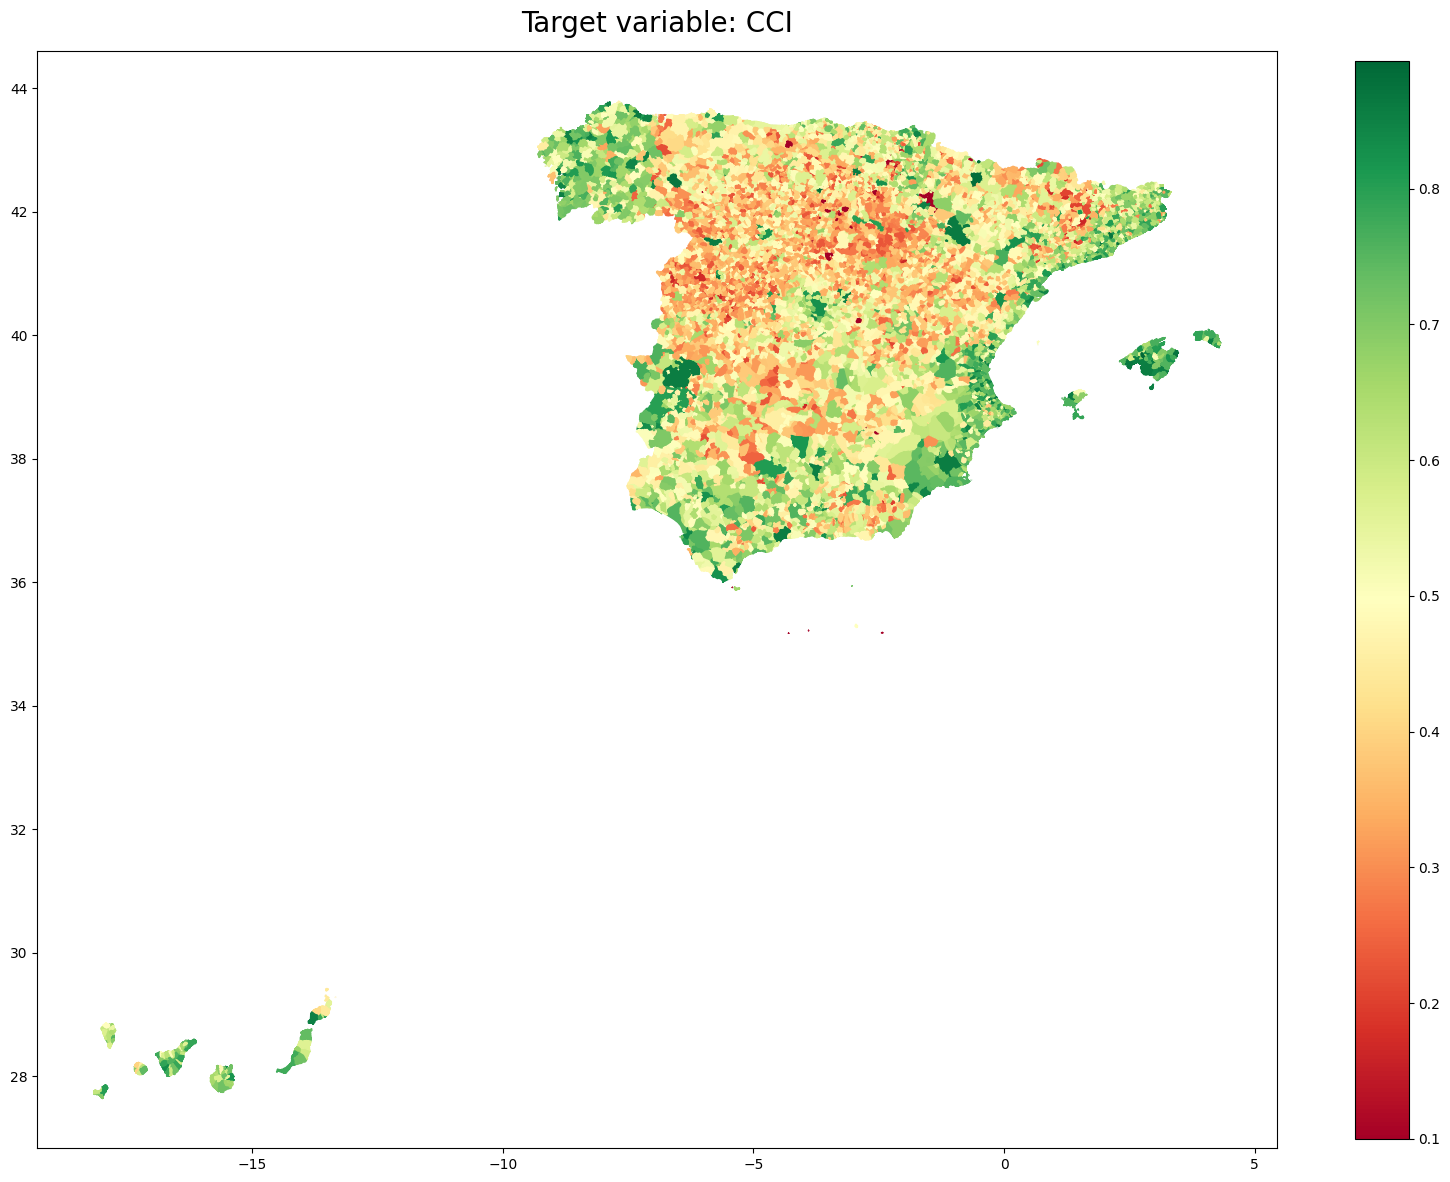

In [12]:
# Plot dependent variable (target variable)
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="RdYlGn",
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_GSA + "target_variable.svg", format="svg")

plt.show()

## Spatial Weights Matrix

In [13]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(geo_info, k=5)

# Row-standardization
w.transform = "R"

## Global Spatial Autocorrelation

### Spatial Lag

In [14]:
# Apply geo_info spatial lag
VARIABLE_TO_PREDICT_lag = VARIABLE_TO_PREDICT + '_lag'
geo_info[VARIABLE_TO_PREDICT_lag] = weights.spatial_lag.lag_spatial(
    w, geo_info[VARIABLE_TO_PREDICT]
)

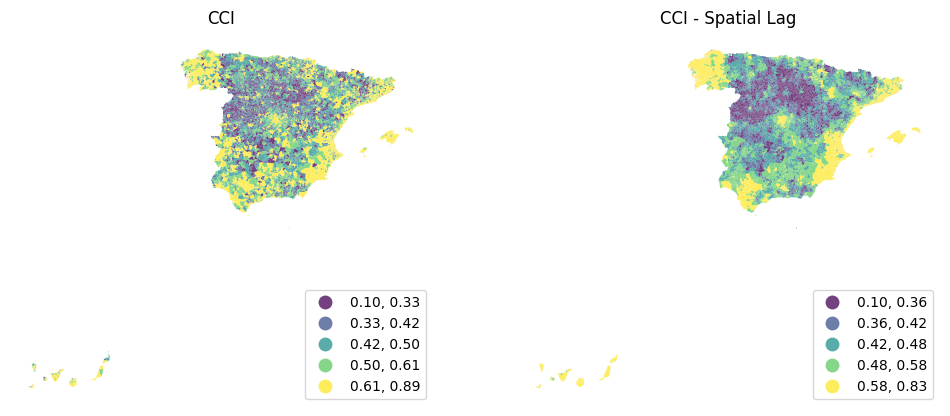

In [15]:
# Plot VARIABLE_TO_PREDICT normal vs VARIABLE_TO_PREDICT with spatial log
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

geo_info.plot(
    column=VARIABLE_TO_PREDICT,
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,    
    legend_kwds={'loc':'lower right'},
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title(str(VARIABLE_TO_PREDICT))

geo_info.plot(
    column=VARIABLE_TO_PREDICT_lag,
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc':'lower right'},
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title(str(VARIABLE_TO_PREDICT) + " - Spatial Lag")

if SAVE_FIGS:
    plt.savefig(DIR_GSA + "normalVSspatiallog.svg", format="svg")

plt.show()

## Moran Plot and Moran's I

In [16]:
VARIABLE_TO_PREDICT_std = VARIABLE_TO_PREDICT + "_std"
VARIABLE_TO_PREDICT_lag_std = VARIABLE_TO_PREDICT + "_lag_std"

# Calculate standard deviation vs standard deviation of log
geo_info[VARIABLE_TO_PREDICT_std] = geo_info[VARIABLE_TO_PREDICT] - geo_info[VARIABLE_TO_PREDICT].mean()
geo_info[VARIABLE_TO_PREDICT_lag_std] = (geo_info[VARIABLE_TO_PREDICT_lag] - geo_info[VARIABLE_TO_PREDICT_lag].mean())

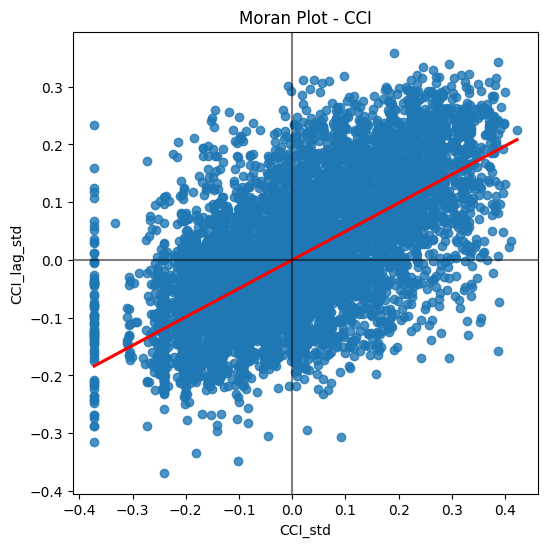

In [17]:
# Create Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x=VARIABLE_TO_PREDICT_std,
    y=VARIABLE_TO_PREDICT_lag_std,
    ci=None,
    data=geo_info,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - " + str(VARIABLE_TO_PREDICT))

if SAVE_FIGS:
    plt.savefig(DIR_GSA + "MoranPlot.svg", format="svg")

plt.show()

In [18]:
w.transform = "R"
moran = esda.moran.Moran(geo_info[VARIABLE_TO_PREDICT], w)

In [19]:
# Calculate Moran's I
moran.I
print("Moran's I value = " + str(moran.I ))

Moran's I value = 0.49355832398166927


In [20]:
# Calculate Moran's I
moran.p_sim
print("Moran's I p-value significance = " + str(moran.p_sim))

# Significance level
if moran.p_sim <= 0.05:
    print("Moran's I is significant")
elif moran.p_sim > 0.05:
    print("Moran's I is NOT significant")

Moran's I p-value significance = 0.001
Moran's I is significant


OSError: [Errno 122] Disk quota exceeded

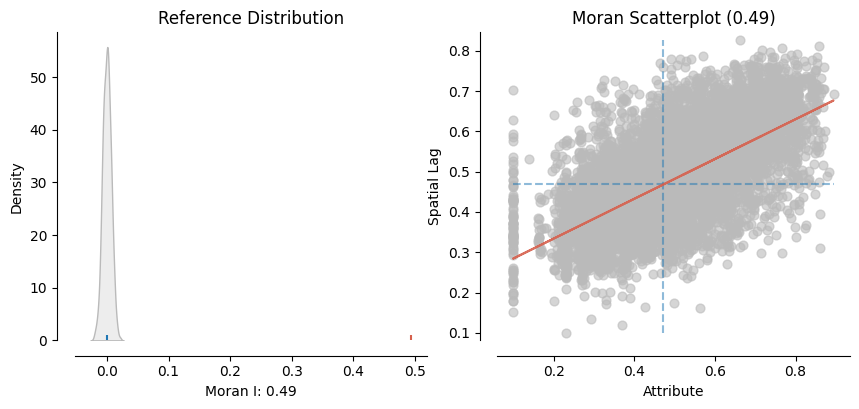

In [21]:
# Plot Moran Scatterplot
plot_moran(moran, zstandard=False);

if SAVE_FIGS:
    plt.savefig(DIR_GSA + "Moran_Scatterplot.svg", format="svg")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>